In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
! git clone https://github.com/ayanokojix21/NeuroFormer.git

Cloning into 'NeuroFormer'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 5), reused 30 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 17.98 KiB | 4.49 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Filtering content: 100% (5/5), 473.25 MiB | 18.11 MiB/s, done.


In [3]:
project_path = "/content/NeuroFormer"

In [4]:
import sys
sys.path.append(project_path)

In [5]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import json

In [6]:
from models.NeuroFormer import NeuroFormer # Importing the core Model
from data.Tokenization import Tokenizer

Vocab Size: 79


In [7]:
# Setting Device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# For Reproducability
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [9]:
# Loading Tokenizer data
with open(f'{project_path}/tokenizer/char2idx.json') as f:
    char2idx = json.load(f)

In [10]:
tokenizer = Tokenizer(char2idx) # Loading tokenizer object

In [11]:
vocab_size = tokenizer.vocab_size
vocab_size

79

In [12]:
# Model HyperParameters
mode = 'decoder_only'
vocab_size = vocab_size
sequence_length = 512
d_model = 512
num_heads = 8
hidden = 4 * d_model
num_layers = 6
drop_prob = 0.2

In [24]:
# Training HyperParameters
batch_size = 32
total_steps = 6000
lr = 3e-4
best_model_path = 'models/pretrain.pt'
os.makedirs('models/', exist_ok = True)

In [14]:
# Data Path
train_path = f'{project_path}/data/pretrain/train.txt'
valid_path = f'{project_path}/data/pretrain/valid.txt'

with open(train_path, 'r', encoding='utf-8') as f:
    train_data = tokenizer.encode(f.read())

with open(valid_path, 'r', encoding='utf-8') as f:
    valid_data = tokenizer.encode(f.read())

train_data = torch.tensor(train_data, dtype=torch.long)
valid_data = torch.tensor(valid_data, dtype=torch.long)

In [15]:
def get_batch(data, batch_size, block_size):
    idx = torch.randint(len(data) - block_size, (batch_size,))
    X = torch.stack([data[i: i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    return X.to(device), y.to(device)

In [16]:
train_loader = get_batch(train_data, batch_size, sequence_length)
valid_loader = get_batch(valid_data, batch_size, sequence_length)

In [25]:
# Building Up Encoder Only Model
model = NeuroFormer(
    mode=mode,
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    d_model=d_model,
    num_heads=num_heads,
    hidden=hidden,
    num_layers=num_layers,
    drop_prob=drop_prob
).to(device)

In [26]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 25,567,311


In [27]:
# Defining Optimizer, scheduler and Criterion
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-4,
    min_lr=1e-6
)

In [28]:
def eval(model, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:

            input_ids, labels = get_batch(train_data, batch_size, sequence_length)

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [29]:
train_losses, val_losses, val_steps = [], [], []

In [30]:
def train_model():
    model.train()
    best_val_loss = float('inf')
    step = 0

    while step < total_steps:
        for batch in train_loader:

            if step >= total_steps:
                break

            input_ids, labels = get_batch(train_data, batch_size, sequence_length)

            optimizer.zero_grad()

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))

            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            train_losses.append(loss.item())

            if step % 200 == 0 or step == total_steps - 1:
                avg_val_loss = eval(model, valid_loader)
                val_losses.append(avg_val_loss)
                val_steps.append(step)
                model.train()

                print(f"Step {step}: Train Loss: {loss.item():.4f}, Val Loss = {avg_val_loss:.4f}")

                prev_lr = optimizer.param_groups[0]['lr']
                lr_scheduler.step(avg_val_loss)
                new_lr = optimizer.param_groups[0]['lr']
                if new_lr != prev_lr:
                    print(f"Learning rate reduced to {new_lr:.6f}")

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Best model saved at step {step}")

            step += 1

In [31]:
train_model()

Step 0: Train Loss: 4.5204, Val Loss = 4.5537
Best model saved at step 0
Step 200: Train Loss: 2.5681, Val Loss = 2.5448
Best model saved at step 200
Step 400: Train Loss: 2.5067, Val Loss = 2.4274
Best model saved at step 400
Step 600: Train Loss: 2.2142, Val Loss = 2.2174
Best model saved at step 600
Step 800: Train Loss: 2.1000, Val Loss = 2.0671
Best model saved at step 800
Step 1000: Train Loss: 1.9487, Val Loss = 1.8907
Best model saved at step 1000
Step 1200: Train Loss: 1.8276, Val Loss = 1.8161
Best model saved at step 1200
Step 1400: Train Loss: 1.7966, Val Loss = 1.6927
Best model saved at step 1400
Step 1600: Train Loss: 1.7448, Val Loss = 1.5850
Best model saved at step 1600
Step 1800: Train Loss: 1.6561, Val Loss = 1.5492
Best model saved at step 1800
Step 2000: Train Loss: 1.6099, Val Loss = 1.6048
Step 2200: Train Loss: 1.5776, Val Loss = 1.5250
Best model saved at step 2200
Step 2400: Train Loss: 1.5741, Val Loss = 1.4484
Best model saved at step 2400
Step 2600: Train 

In [32]:
def visualize(train_losses, val_losses, val_steps):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_steps, val_losses, label='Val Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

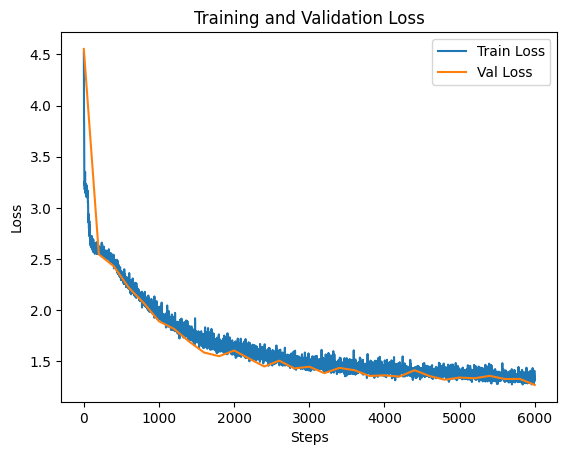

In [33]:
visualize(train_losses, val_losses, val_steps)

In [36]:
import torch
import torch.nn as nn

@torch.no_grad()
def generate(model, tokenizer, start_text='', max_new_tokens=300, block_size=256, device='cuda'):
    model.eval()

    context_ids = tokenizer.encode(start_text)
    context = torch.tensor(context_ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):

        input_ids = context[:, -block_size:]

        logits = model(input_ids)
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)

        context = torch.cat((context, next_token), dim=1)

    output_text = tokenizer.decode(context[0].tolist())
    return output_text

In [38]:
generate(model, tokenizer, 'Once upon a time, in a small village')

"Once upon a time, in a small village and assets was conducted at it was valued against the football which uses the smaller at their next football which am titled and carrying what I'd actually use these who tipped with new SA includes a space in Area and I'm going to get keep after the other lack of them. A question of them. As if I d"